In [1]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools
from tqdm import tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

In [18]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = InteractiveSession(config=config)

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Scaling Up our CNN Model

From here onwards we're going to use the full 101 of food classes,
using splitting them from 75% - 25% train and test chronologically,
and generating 10% of the data from the train set.

What we're left of is 101 classes with 75 images each for the train set and 250 images for the test set.

[101 Food Dataset Paper](https://paperswithcode.com/dataset/food-101)

> To measure the performance of our rf component mining for food recognition, we introduce a novel and challenging dataset of 101 food categories, with 101’000 images. With an average accuracy of **50.76%**, our model outperforms alternative classification methods except for cnn

To gain more experience in the future, we'll do another project similar to this and beat their model score

### Parsing through the data

In [88]:
train_101_50_dir = './Food-Vision-REDO/datasets/food_101/train_50/'
train_101_20_dir = './Food-Vision-REDO/datasets/food_101/train_20/'
train_101_10_dir = './Food-Vision-REDO/datasets/food_101/train_10/'
test_101_dir = './Food-Vision-REDO/datasets/food_101/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101/'

In [21]:
class_list_all = glob(os.path.join(test_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;
len(class_list_all)

101

In [22]:
def plot_history_curves(model):
    '''
    Plots a model's history metric
    
    Parameters
    ------
    model - model history
    '''
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    
    accuracy = model.history['accuracy']
    val_accuracy = model.history['val_accuracy']
    
    epochs = range(len(model.history['loss']))
    
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss[lower == better]')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Val Accuracy')
    plt.title('Accuracy[higher==better]')
    plt.xlabel('Epochs')
    plt.legend()

In [126]:
def plot_random_image(class_list, directory, titles=True):
    
    '''
    Takes in a list of classes which randomly selects an image in its directory
    and outputs the image file, along with the img directory
    
    Parameters
    --------
    class_list - list of classes(similar to its folder name)
    directory - location of images you would want to view
    '''
    
    random_class = random.choice(class_list)
    random_dir = directory + random_class
    random_img = random.choice(os.listdir(random_dir))
    rng_dir_img = random_dir + '/' + random_img
    arr_dir_img = mpimg.imread(rng_dir_img)
    
    plt.axis(False)
    if titles:
        img=plt.imshow(arr_dir_img)
        plt.title(f'class:{random_class}\n shape:{arr_dir_img.shape}\n {random_img}')
    else:
        img=plt.imshow(arr_dir_img)
        
    return img, rng_dir_img

In [24]:
def compare_history(original_history, new_history, initial_epochs):
    '''
    Input model_2 then new history to show frequency of the train and val loss
    '''
    
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation History')
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

In [25]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    '''
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    '''
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=90)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

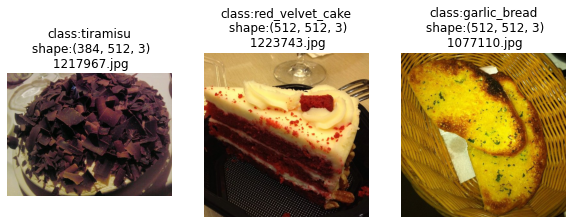

In [26]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_random_image(class_list=class_list_all, directory=train_101_10_dir)

In [89]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_10_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

train_data_20_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_20_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

train_data_50_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_50_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_101_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 37875 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Generating a checkpoint callback

In [28]:
def create_checkpoint_callback(checkpoint_path, metric):
    '''
    creates a checkpoint callback
    
    Parameters
    -----
    checkpoint_path - destination file path
    '''
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=metric,
        save_weights_only=True,
        save_best_only=True,
    )
    return checkpoint_callback

In [29]:
chck_pth = './Food-Vision-REDO/checkpoint/checkpoint.ckpt'
checkpoint_callback = create_checkpoint_callback(chck_pth, metric='accuracy')

## Building our CNN Model

#### Building Model 0

**Experiment** - Model 0  
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model 


In [70]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name = 'data_augmentation')

In [71]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = tf.keras.layers.Dense(len(class_list_all), activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)


In [72]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

model_0_history = model_0.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 32s 111ms/step - loss: 3.4271 - accuracy: 0.2566 - val_loss: 2.8623 - val_accuracy: 0.3424
Epoch 2/5
237/237 [==============================] - 25s 104ms/step - loss: 2.2833 - accuracy: 0.4752 - val_loss: 2.4535 - val_accuracy: 0.4102
Epoch 3/5
237/237 [==============================] - 25s 104ms/step - loss: 1.9176 - accuracy: 0.5456 - val_loss: 2.2611 - val_accuracy: 0.4431
Epoch 4/5
237/237 [==============================] - 25s 103ms/step - loss: 1.6885 - accuracy: 0.5939 - val_loss: 2.1982 - val_accuracy: 0.4529
Epoch 5/5
237/237 [==============================] - 25s 103ms/step - loss: 1.5554 - accuracy: 0.6206 - val_loss: 2.1670 - val_accuracy: 0.4597


In [74]:
model_0_evaluation = model_0.evaluate(test_data)
model_0_evaluation

790/790 [==============================] - 50s 64ms/step - loss: 1.8764 - accuracy: 0.5212


[1.8764320611953735, 0.5211881399154663]

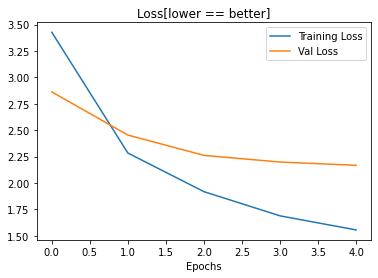

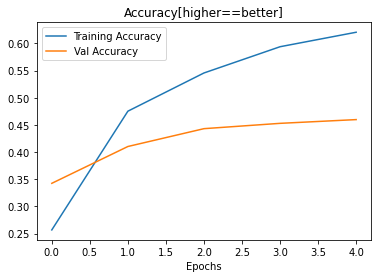

In [75]:
plot_history_curves(model_0_history)

The model is definitely learning, but is also overfitting on the later epochs

####  Building Model 1

**Experiment** - Model 1   
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning
**Checkpoint** - From the final epoch of the previous model(tf_model_2)

* make last 10 trainable for `base_model` 
* use `tf_model_2` to compile and fit
* when fitting change `initial epoch` to tf_model_2's final `epoch`
* increase the `epochs` and `learning rate`

> 🔑 When increasing `learning_rate` also increase `epochs`

In [80]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False
    
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=['accuracy'])

In [81]:
model_1_history = model_0.fit(
    train_data_10_percent,
    epochs=len(model_0_history.epoch)+5,
    initial_epoch=model_0_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/10
237/237 [==============================] - 33s 111ms/step - loss: 1.2902 - accuracy: 0.6957 - val_loss: 2.0220 - val_accuracy: 0.4979
Epoch 6/10
237/237 [==============================] - 24s 103ms/step - loss: 1.2835 - accuracy: 0.6960 - val_loss: 2.0195 - val_accuracy: 0.4979
Epoch 7/10
237/237 [==============================] - 26s 107ms/step - loss: 1.2663 - accuracy: 0.6991 - val_loss: 2.0249 - val_accuracy: 0.4984
Epoch 8/10
237/237 [==============================] - 25s 104ms/step - loss: 1.2624 - accuracy: 0.7006 - val_loss: 2.0170 - val_accuracy: 0.5000
Epoch 9/10
237/237 [==============================] - 25s 106ms/step - loss: 1.2505 - accuracy: 0.7017 - val_loss: 2.0152 - val_accuracy: 0.5005
Epoch 10/10
237/237 [==============================] - 27s 113ms/step - loss: 1.2284 - accuracy: 0.7125 - val_loss: 2.0185 - val_accuracy: 0.4984


In [83]:
model_1_evaluation = model_0.evaluate(test_data)
model_1_evaluation

790/790 [==============================] - 51s 64ms/step - loss: 1.8175 - accuracy: 0.5375


[1.8175270557403564, 0.5375445485115051]

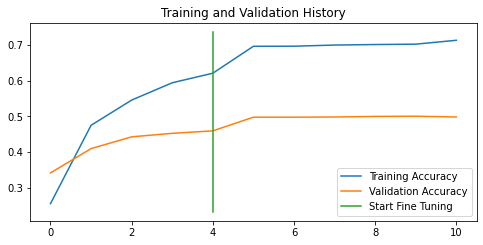

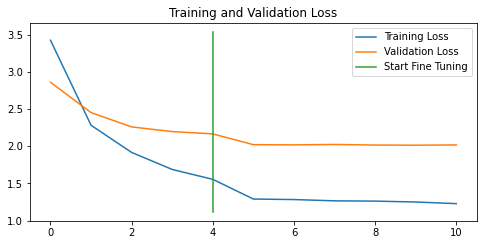

In [84]:
compare_history(model_0_history, model_1_history, initial_epochs=5)

####  Building Model 2

**Experiment** - Model 2   
**Data** - 50%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning  
**Checkpoint** - From the final epoch of the previous model(tf_model_2)


In [90]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

model_2_history = model_0.fit(
    train_data_50_percent,
    epochs=len(model_0_history.epoch)+5,
    initial_epoch=model_0_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/10
1184/1184 [==============================] - 95s 75ms/step - loss: 1.8153 - accuracy: 0.5498 - val_loss: 1.9565 - val_accuracy: 0.5101
Epoch 6/10
1184/1184 [==============================] - 88s 74ms/step - loss: 1.7623 - accuracy: 0.5605 - val_loss: 1.9109 - val_accuracy: 0.5207
Epoch 7/10
1184/1184 [==============================] - 87s 74ms/step - loss: 1.7231 - accuracy: 0.5702 - val_loss: 1.8822 - val_accuracy: 0.5270
Epoch 8/10
1184/1184 [==============================] - 88s 74ms/step - loss: 1.6899 - accuracy: 0.5758 - val_loss: 1.8677 - val_accuracy: 0.5291
Epoch 9/10
1184/1184 [==============================] - 88s 74ms/step - loss: 1.6615 - accuracy: 0.5810 - val_loss: 1.8300 - val_accuracy: 0.5381
Epoch 10/10
1184/1184 [==============================] - 89s 75ms/step - loss: 1.6332 - accuracy: 0.5899 - val_loss: 1.8168 - val_accuracy: 0.5450


In [92]:
model_2_evaluation = model_0.evaluate(test_data)
model_2_evaluation

790/790 [==============================] - 51s 65ms/step - loss: 1.6302 - accuracy: 0.5800


[1.630167841911316, 0.5800396203994751]

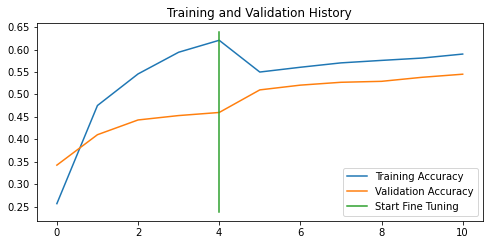

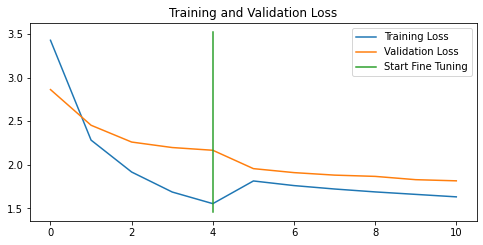

In [93]:
compare_history(model_0_history, model_2_history, initial_epochs=5)

#### Building Model 3

**Experiment** - Model 2   
**Data** - 50%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning  
**Checkpoint** - From the final epoch of the previous model(tf_model_2)
`learning_rate` = 0.00001  
`epochs` = + 10  
`trainable layers` = [:-10]

In [95]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])

model_3_history = model_0.fit(
    train_data_50_percent,
    epochs=len(model_0_history.epoch)+10,
    initial_epoch=model_0_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/15
1184/1184 [==============================] - 93s 74ms/step - loss: 1.6090 - accuracy: 0.5954 - val_loss: 1.8046 - val_accuracy: 0.5471
Epoch 6/15
1184/1184 [==============================] - 87s 73ms/step - loss: 1.6064 - accuracy: 0.5968 - val_loss: 1.8004 - val_accuracy: 0.5493
Epoch 7/15
1184/1184 [==============================] - 88s 74ms/step - loss: 1.6064 - accuracy: 0.5963 - val_loss: 1.7973 - val_accuracy: 0.5490
Epoch 8/15
1184/1184 [==============================] - 88s 74ms/step - loss: 1.6025 - accuracy: 0.5989 - val_loss: 1.7960 - val_accuracy: 0.5503
Epoch 9/15
1184/1184 [==============================] - 88s 74ms/step - loss: 1.5995 - accuracy: 0.5983 - val_loss: 1.7921 - val_accuracy: 0.5506
Epoch 10/15
1184/1184 [==============================] - 89s 75ms/step - loss: 1.5939 - accuracy: 0.5997 - val_loss: 1.7906 - val_accuracy: 0.5524
Epoch 11/15
1184/1184 [==============================] - 87s 73ms/step - loss: 1.5941 - accuracy: 0.5995 - val_loss: 1.7897

In [96]:
model_3_evaluation = model_0.evaluate(test_data)

790/790 [==============================] - 51s 65ms/step - loss: 1.6120 - accuracy: 0.5859


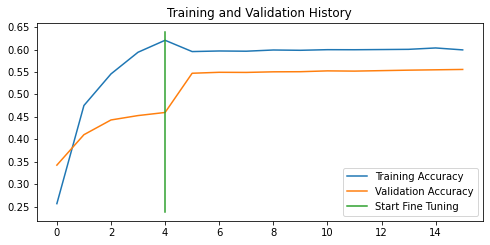

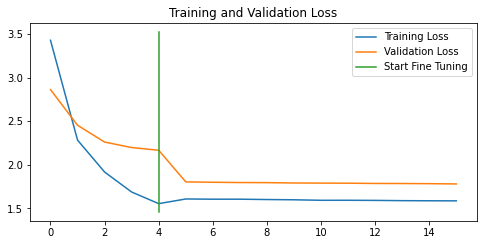

In [97]:
compare_history(model_0_history, model_3_history, initial_epochs=5)

The data overfitted after training till 7 epochs. 
I'll either use 100% of the data, or just update the layers.
but as for now, reaching near 60% validation accuracy is my target

In [98]:
model_0.save(filepath='./Food-Vision-REDO/models/101_food_class_50_percent_model.h5')

C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


###  [Postponed until fixed] Saving and loading our model

loading a model with hd5 file is slightly different that the model at hand
saving a model compiled with regular .tf file isn't working and causes an error when done so

In [47]:
#model_0.save(filepath='./Food-Vision-REDO/models/101_food_class_10_percent_model')

In [ ]:
# loaded_model = tf.keras.models.load_model('./Food-Vision-REDO/models/101_food_class_10_percent_model.h5')
# loaded_model.trainable = True

# for layer in loaded_model.layers[2].layers[:-5]:
#     layer.trainable = False
        
# loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                        metrics=['accuracy'])

# loaded_model_history = loaded_model.fit(
#     train_data_all_10_percent,
#     epochs=len(model_0_history.epoch)+5,
#     initial_epoch=model_0_history.epoch[-1],
#     validation_data=test_data,
#     validation_steps=int(0.15*len(test_data)),
#     callbacks=[checkpoint_callback]
# )

In [ ]:
# loaded_model_results = loaded_model.evaluate(test_data)
# loaded_model_results

In [ ]:
#for layer in loaded_model.layers:
#    print(layer.name, layer.trainable)

In [ ]:
#for layer_number, layer in enumerate(loaded_model.layers[2].layers):
#    print(layer_number, layer.name, layer.trainable)

In [ ]:
#loaded_model.summary()

### Using the Pretrained Model and Making Predictions

In [99]:
pred_probs = model_0.predict(test_data, verbose=1)

790/790 [==============================] - 50s 62ms/step


In [101]:
pred_probs.shape

(25250, 101)

In [102]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([2.97915995e-01, 2.89230025e-03, 5.70105426e-02, 3.02574572e-05,
        9.28731926e-04, 1.97647455e-06, 1.30227543e-02, 4.41805651e-06,
        1.43107343e-02, 1.02689453e-04, 1.61106931e-03, 1.73823719e-05,
        1.04815634e-02, 6.28410198e-05, 3.73883347e-04, 5.80369197e-05,
        9.13403346e-04, 4.93181113e-04, 1.70338585e-03, 2.86961440e-04,
        8.60511325e-04, 5.91625212e-05, 7.43541241e-05, 1.02020463e-03,
        3.69369045e-05, 2.02142261e-03, 3.88577173e-05, 2.00214199e-05,
        1.80375110e-03, 7.64848897e-04, 1.51109434e-05, 1.01072555e-02,
        2.11184025e-02, 2.13727944e-05, 1.60144300e-05, 1.73358116e-04,
        7.91065759e-06, 5.29438257e-04, 1.57727161e-03, 1.99850110e-04,
        6.27800962e-03, 9.39019301e-05, 1.21001033e-02, 1.00545061e-03,
        2.14153752e-05, 1.81204837e-06, 9.36212018e-02, 2.47087050e-03,
        5.57992848e-07, 6.84618764e-03, 2.21574446e-03, 1.14899063e-04,
        2.72489309e-01, 1.02129835e-03, 3.76832600e-06, 3.049362

In [103]:
print(f'Number of prediction probability for sample 0:{len(pred_probs[0])}') 
print(f'What Prediction Probability sample 0 looks like: \n{pred_probs[0]}')
print(f'What class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}')

Number of prediction probability for sample 0:101
What Prediction Probability sample 0 looks like: 
[2.97915995e-01 2.89230025e-03 5.70105426e-02 3.02574572e-05
 9.28731926e-04 1.97647455e-06 1.30227543e-02 4.41805651e-06
 1.43107343e-02 1.02689453e-04 1.61106931e-03 1.73823719e-05
 1.04815634e-02 6.28410198e-05 3.73883347e-04 5.80369197e-05
 9.13403346e-04 4.93181113e-04 1.70338585e-03 2.86961440e-04
 8.60511325e-04 5.91625212e-05 7.43541241e-05 1.02020463e-03
 3.69369045e-05 2.02142261e-03 3.88577173e-05 2.00214199e-05
 1.80375110e-03 7.64848897e-04 1.51109434e-05 1.01072555e-02
 2.11184025e-02 2.13727944e-05 1.60144300e-05 1.73358116e-04
 7.91065759e-06 5.29438257e-04 1.57727161e-03 1.99850110e-04
 6.27800962e-03 9.39019301e-05 1.21001033e-02 1.00545061e-03
 2.14153752e-05 1.81204837e-06 9.36212018e-02 2.47087050e-03
 5.57992848e-07 6.84618764e-03 2.21574446e-03 1.14899063e-04
 2.72489309e-01 1.02129835e-03 3.76832600e-06 3.04936222e-03
 2.17257417e-04 8.20715725e-03 6.79302146e-04 

In [104]:
test_data.class_names[0]

'apple_pie'

In [106]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0, 14, 98,  2, 68, 72,  0, 21,  2,  0], dtype=int64)

In [107]:
len(pred_classes)

25250

In [108]:
y_labels = []

for images, labels in tqdm(test_data.unbatch()):
        y_labels.append(labels.numpy().argmax())
        
y_labels[:10]

25250it [00:10, 2432.57it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [109]:
len(y_labels)

25250

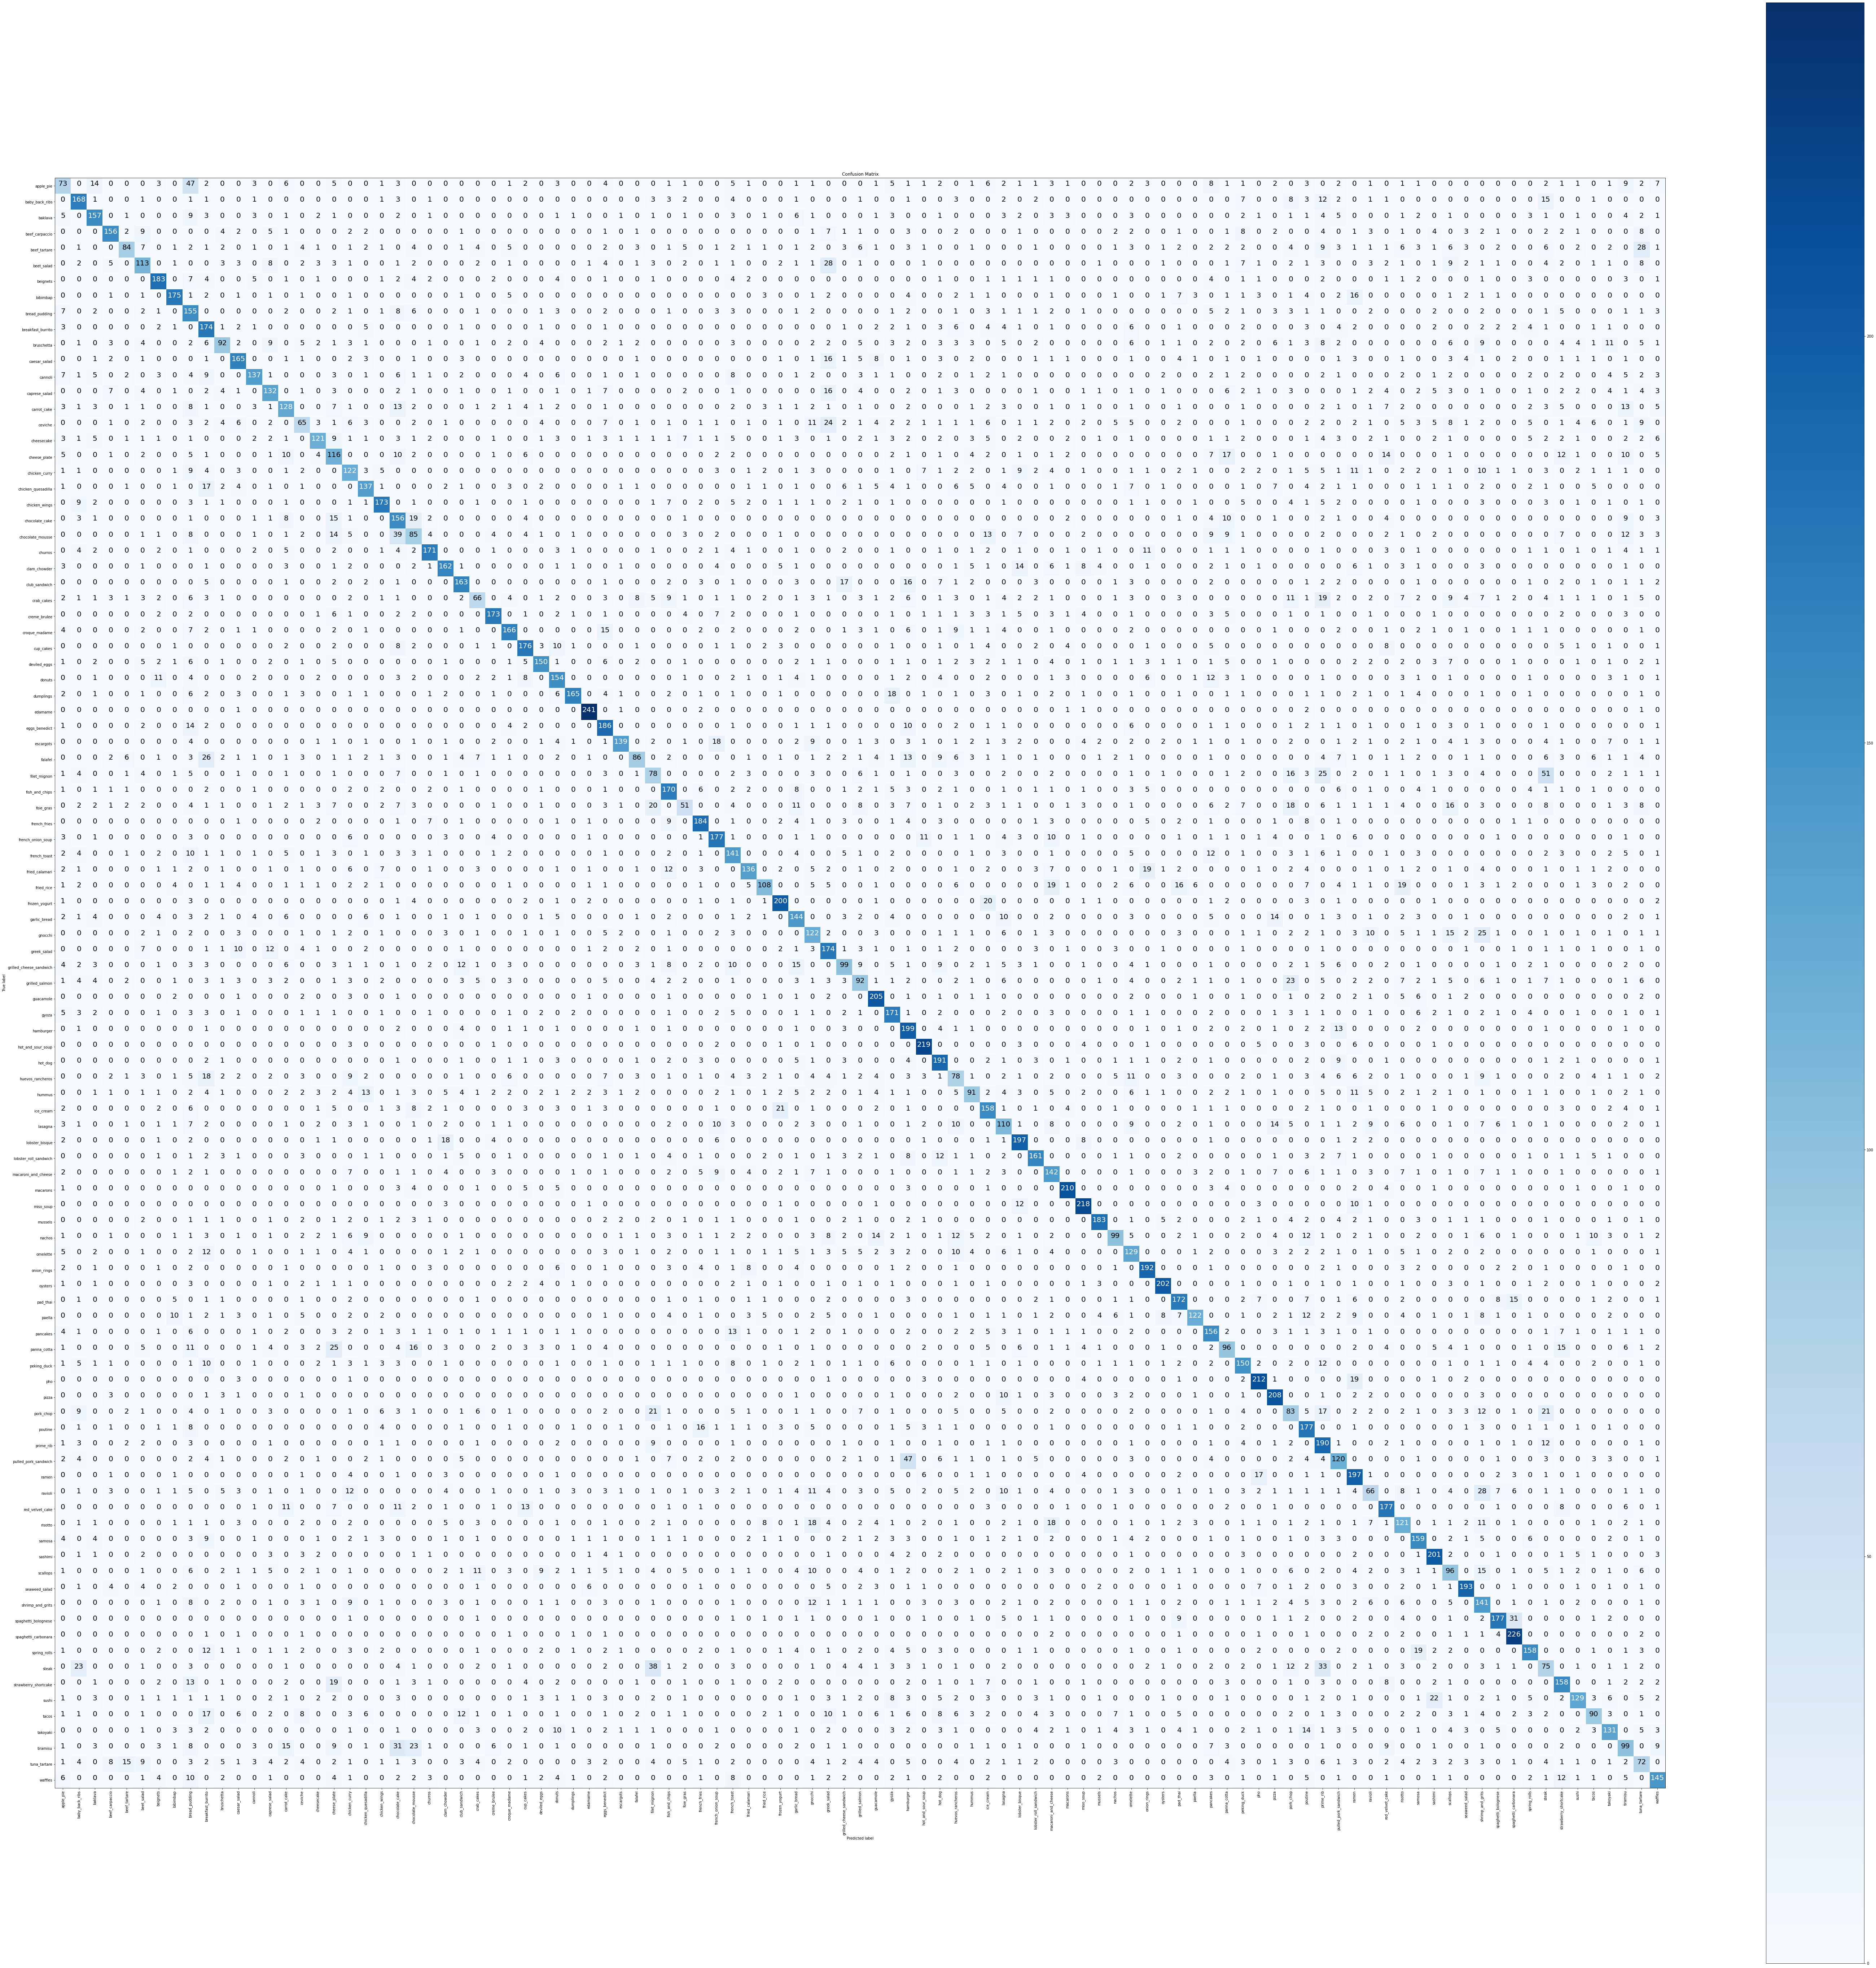

In [110]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_list_all, figsize=(100,100), text_size=20)


In [111]:
classification_report_dict = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)

In [112]:
class_f1_scores = {}

for key, value in classification_report_dict.items():
    if key == 'accuracy':
        break
    else:
        class_f1_scores[class_list_all[int(key)]] = value['f1-score']

In [113]:
class_f1_scores

{'apple_pie': 0.3333333333333333,
 'baby_back_ribs': 0.6412213740458016,
 'baklava': 0.6487603305785123,
 'beef_carpaccio': 0.6812227074235807,
 'beef_tartare': 0.4456233421750664,
 'beet_salad': 0.4870689655172414,
 'beignets': 0.7364185110663984,
 'bibimbap': 0.7415254237288137,
 'bread_pudding': 0.4183535762483131,
 'breakfast_burrito': 0.537037037037037,
 'bruschetta': 0.45098039215686275,
 'caesar_salad': 0.6639839034205232,
 'cannoli': 0.6327944572748267,
 'caprese_salad': 0.5653104925053534,
 'carrot_cake': 0.5224489795918368,
 'ceviche': 0.32098765432098764,
 'cheesecake': 0.5721040189125296,
 'cheese_plate': 0.4195298372513563,
 'chicken_curry': 0.46923076923076923,
 'chicken_quesadilla': 0.5879828326180259,
 'chicken_wings': 0.7178423236514522,
 'chocolate_cake': 0.5,
 'chocolate_mousse': 0.3578947368421052,
 'churros': 0.735483870967742,
 'clam_chowder': 0.6666666666666666,
 'club_sandwich': 0.6626016260162602,
 'crab_cakes': 0.3402061855670103,
 'creme_brulee': 0.7377398720

In [114]:
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                   'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [115]:
f1_scores['f1-score']

33    0.928709
63    0.850202
54    0.834286
69    0.831276
64    0.819549
        ...   
15    0.320988
82    0.320388
99    0.305732
39    0.288136
93    0.286260
Name: f1-score, Length: 101, dtype: float64

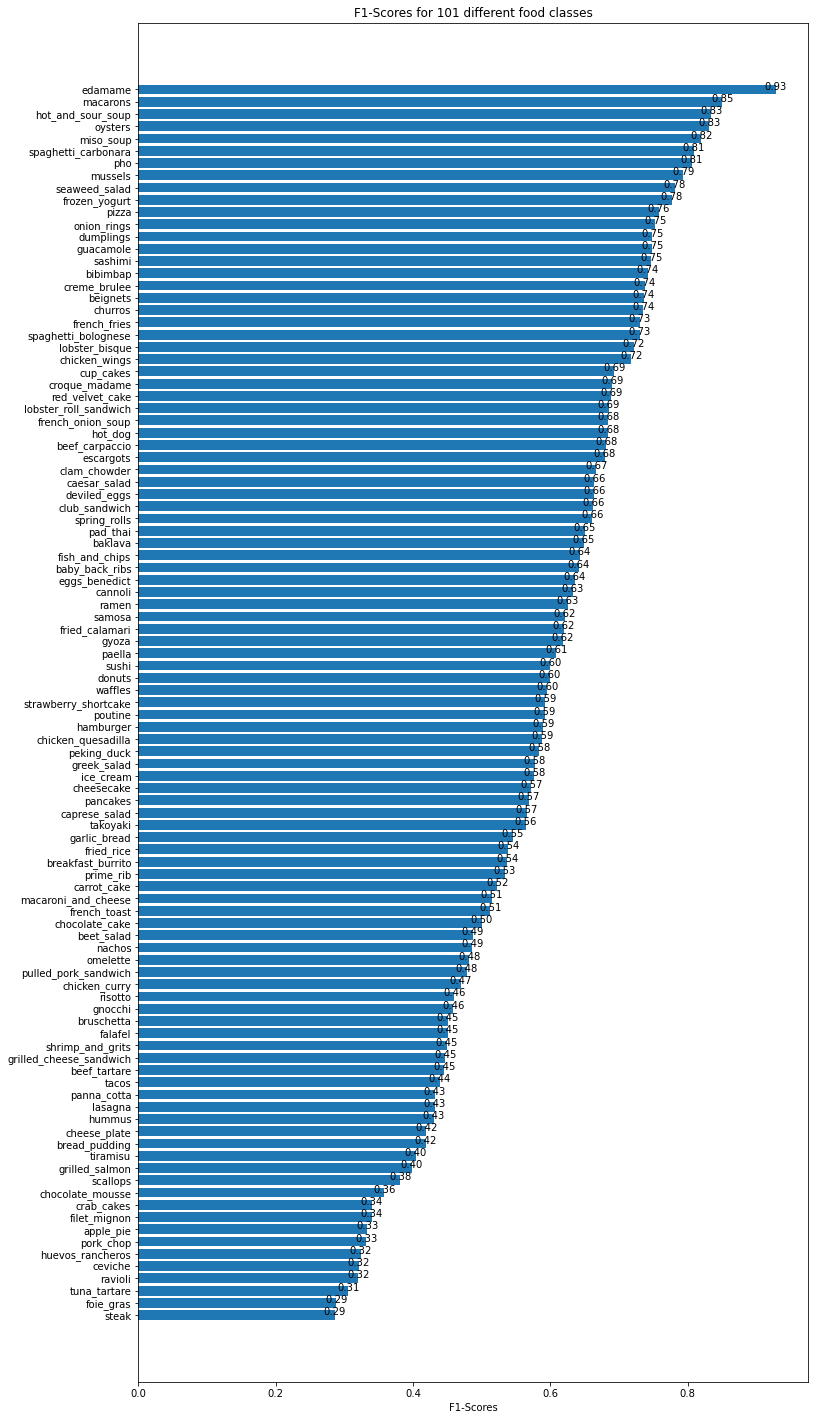

In [116]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names']);
ax.set_xlabel('F1-Scores')
ax.set_title('F1-Scores for 101 different food classes')
ax.invert_yaxis();

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')
        
autolabel(scores)

In [123]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    img = tf.io.read_file(filename)
    
    img = tf.io.decode_image(img, channels=3)
    
    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    if scale:
        return img/255.
    else:
        return img

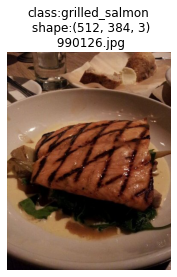

In [131]:
random_class = [np.random.choice(class_list_all)]
img, img_dir = plot_random_image(random_class, test_101_dir, titles=True)

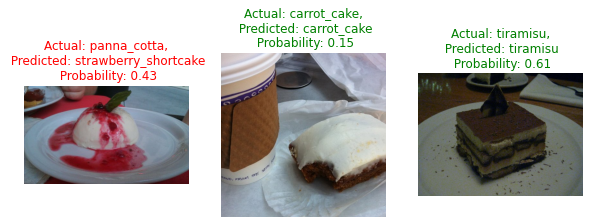

In [134]:
plt.figure(figsize=(10,10))
for i in range(3):
    random_class = [np.random.choice(class_list_all)]
    plt.subplot(1,3, i+1)
    img, img_dir = plot_random_image(random_class, test_101_dir, titles=False)
    img = load_and_prep_image(img_dir, scale=False)
    pred_prob = model_0.predict(tf.expand_dims(img, axis=0))
    pred_class = class_list_all[pred_prob.argmax()]
    plt.axis(False)
    if random_class[0] == pred_class:
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f'Actual: {random_class[0]},\n Predicted: {pred_class}\n Probability: {pred_prob.max():.2f}', c=title_color)